In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from numpy.lib.stride_tricks import sliding_window_view
import glob 
from scipy import signal
from scipy.fft import fft, fftfreq

In [3]:

def fft_(input_array, sampling_points, fs):
    # Number of sample points
    N = sampling_points
    # sample spacing == 1/fs
    T = 1.0 / fs
    # Compute the FFT 
    yf = (fft(input_array, axis = 1))    
    yf_trim = 2.0/N * np.abs(yf[0:N//2, :])
    
    xf = fftfreq(N, T)[:N//2]
    f_res = {'freq': xf, 
            'fft': yf_trim}
    return f_res




def over_lapping_rolling(X, input_dim = 100, sensors = None):
    """
    Convert 1-D Time-series raw data to small 1-second windows.
    :params x:       1-D Time-series raw data.   
    :params sensors: dictionary includes name of sensors.
    :return:         Small 1-second windows. 
    """
    if sensors is None: 
        return sliding_window_view(X, window_shape = input_dim).T 
    return {sensor: sliding_window_view(X[sensor], window_shape = input_dim).T for sensor in sensors}

def energy_(X, input_dim):
    """
    Returns the Energy of one second of a time-series array.
    
    :params X: 1-D array of 1 sencond of data. 
    :return:   Energy = 1/n * (sum(samples**2))
    """
    return np.sum(X**2, axis = 0)/input_dim

In [4]:
path_indoor = '../data/piezo/00_indoor_normal_cond.dat'
path_outdoor = '../data/piezo/00_outdoor_normal_cond_220622.dat'
def load_data(path):
    data = pd.DataFrame(np.loadtxt(path,  unpack = True).T , columns=['Ts', 'N.A', 'Velocity', 'CH0', 'CH1'])
    #data = [np.loadtxt(f,  unpack = True) for f in glob.glob(path + "*.dat")]
    return data


#data_floor4 = load_data(path+'_floor4/')
#data_floor3 = load_data(path+'_floor3/')
#data_floor2 = load_data(path+'_floor2/')
#data_floor1 = load_data(path+'_floor1/')


#data = {'f1': data_floor1, 'f2':data_floor2, 'f3':data_floor3, 'f4':data_floor4}

indoor_data = load_data(path= path_indoor)
outdoor_data = load_data(path= path_outdoor)


outdoor_data.head()


,Ts,N.A,Velocity,CH0,CH1
0,0.01,0.0,0.0,-0.001157,0.002822
1,0.02,0.0,0.0,-0.000158,0.002104
2,0.03,0.0,0.0,0.000431,0.001235
3,0.04,0.0,0.0,0.000409,0.000337
4,0.05,0.0,0.0,0.001051,-0.000249


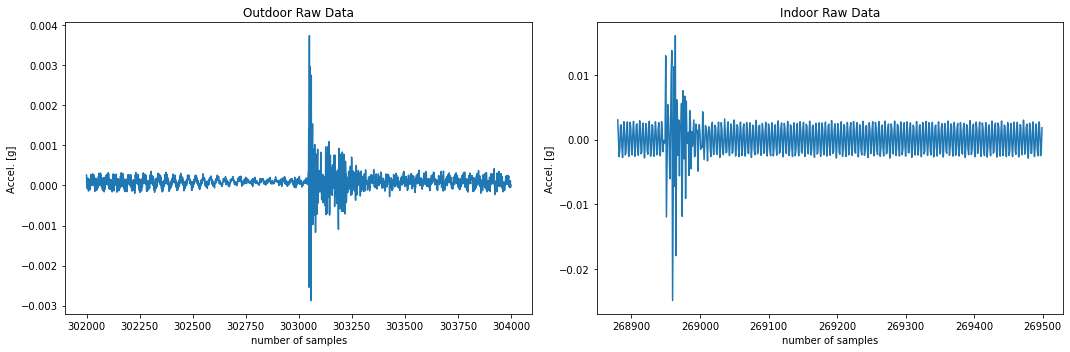

In [25]:

plt.figure(figsize=(15,5))
plt.subplot2grid( (1,2), (0,0))
plt.plot(outdoor_data.CH1[30_2000:30_4000])
plt.title("Outdoor Raw Data")
plt.xlabel("number of samples")
plt.ylabel("Accel. [g]")
plt.subplot2grid( (1,2), (0,1))
plt.plot(indoor_data.CH1[268_880:269_500])
plt.title("Indoor Raw Data")
plt.xlabel("number of samples")
plt.ylabel("Accel. [g]")
plt.savefig("../WR.svg")
plt.tight_layout()
plt.show()

4576


<IPython.core.display.Javascript object>


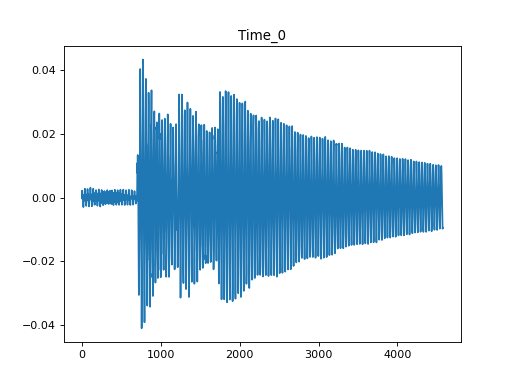

<IPython.core.display.Javascript object>


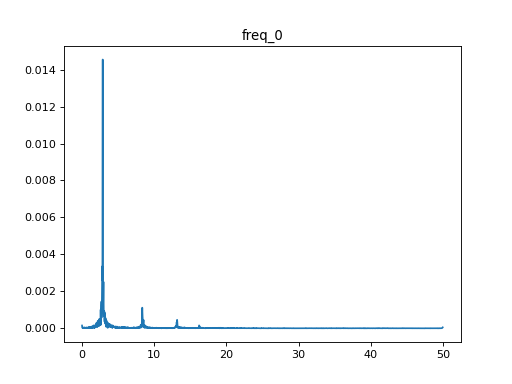

In [6]:
%matplotlib notebook
# just plot 1 condition :) 
i = 0
temp = data['f1'][i]
print(temp.shape[1])
plt.figure()
plt.plot(temp[4,:])
_fft = fft_(temp, temp.shape[1],100)

#max_freq.append(_fft['freq'][np.argmax(_fft['fft'][4,: int(data[i].shape[1]/2)])])


plt.title(f"Time_{i}")
plt.figure()
#plt.plot(_fft['freq'], _fft['fft'][4,: int(data[i].shape[1]/2)])
plt.plot(_fft['freq'], _fft['fft'][4,: int(temp.shape[1]/2)])

plt.title(f"freq_{i}")
plt.show()

In [7]:
from scipy.signal import find_peaks
max_freq_ch2 = {}
max_freq_ch1 = {}
peaks_last = {}

def freq_peak_finder(freq_range, fft_amp, n_samples, ch):
    return freq_range[np.argmax(fft_amp[ch,0: int(n_samples/2)])]


def from_raw_to_peak(data, fs, channel):
    ch4 = []
    ch3 = []
    for i in range(0, 9):
        _fft = fft_(data[i], data[i].shape[1],fs)
        ch4.append(freq_peak_finder(_fft['freq'], _fft['fft'], int(data[i].shape[1]/2), channel))
        
    
    return np.array(ch4)
        #.reshape((10,1))
        
def peak_floors(data, fs, floors, ch): 
    return {floor: from_raw_to_peak(data[floor], fs, ch) for floor in floors}
        
        



In [8]:
floors = ['f1', 'f2', 'f3', 'f4']

columns_labels = [
    '1.5Kg',
    '2.8Kg',
    '3.5Kg',
    '4.5Kg',
    '5.5Kg',
    '6.5Kg',
    '7.5Kg',
    '8.5Kg',
    '9.5Kg']
floor_peaks_ch4 = pd.DataFrame.from_dict(peak_floors(data, 100, floors, 4), orient= 'index', columns=columns_labels)
floor_peaks_diff_ch4 =  2.85 - floor_peaks_ch4
floor_peaks_ch3 = pd.DataFrame.from_dict(peak_floors(data, 100, floors, 3), orient= 'index', columns=columns_labels)
floor_peaks_ch4
#print(floor4_peaks['ch1'].shape)

,1.5Kg,2.8Kg,3.5Kg,4.5Kg,5.5Kg,6.5Kg,7.5Kg,8.5Kg,9.5Kg
f1,2.862762,2.847633,2.840909,2.836538,2.838828,2.833104,2.824519,2.836538,2.836538
f2,2.820513,2.815934,2.810651,2.810651,2.804487,2.775350,2.792160,2.764423,2.764423
f3,2.824519,2.800481,2.788462,2.752404,2.738294,2.712912,2.712912,2.681213,2.678571
f4,2.804487,2.768875,2.735411,2.728365,2.694838,2.684295,2.662722,2.644231,2.624199


<IPython.core.display.Javascript object>


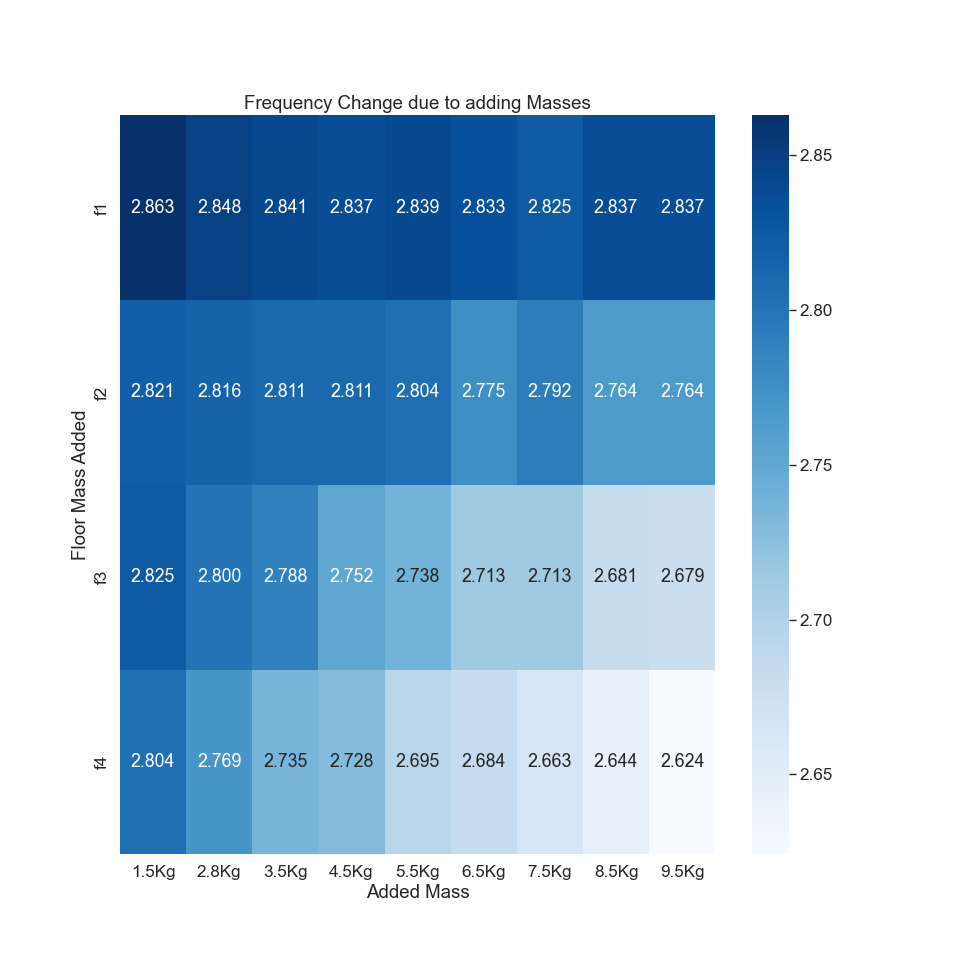

In [9]:
import seaborn as sn 
plt.figure(figsize=(12,12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(floor_peaks_ch4, annot=True, fmt=".3f", annot_kws={"size": 16}, cmap = 'Blues')
plt.title('Frequency Change due to adding Masses')
plt.ylabel('Floor Mass Added')
plt.xlabel('Added Mass')
plt.savefig('../plots/freq_change.svg')
plt.show()

<IPython.core.display.Javascript object>


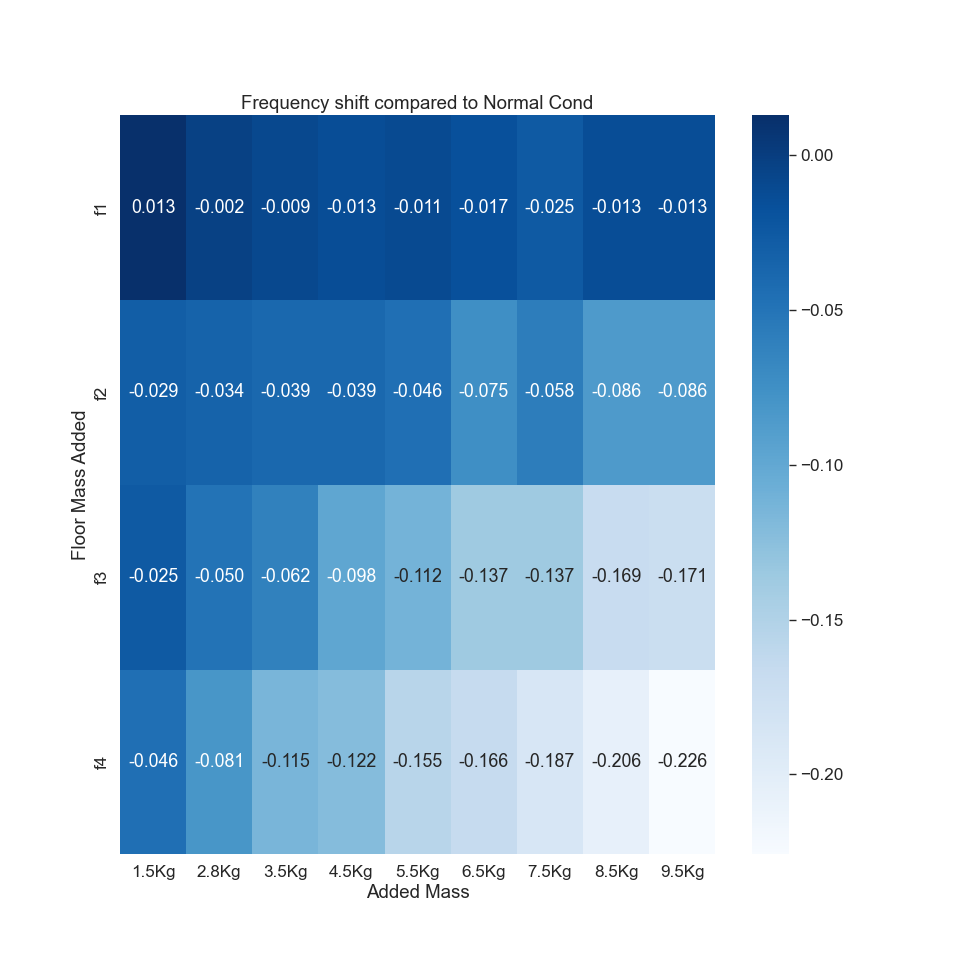

In [10]:
import seaborn as sn 
plt.figure(figsize=(12,12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(-1*floor_peaks_diff_ch4, annot=True, fmt=".3f", annot_kws={"size": 16}, cmap = 'Blues')
plt.title('Frequency shift compared to Normal Cond')
plt.ylabel('Floor Mass Added')
plt.xlabel('Added Mass')
plt.savefig('../plots/difference_to_nom_vals.svg')
plt.show()